# Bulk analysis of constant velocity experiments
In this notebook we take a large number of constant velocity traces and inspect each of them for:
- Unfolding events
- Experimental errors
  - Multiple tethers
  - Bead loss  **(missing)**
  - Outside interference  **(missing)**

After which we determine the contour lengths of unfolded domains, as well as their unfolding forces, by fitting each curve with Odijk and Marko-Siggia models (for DNA handles and unfolded protein respectively).

This is very much a work in progress and there are some things to keep in mind (also a todo/fix list):
- For now, fdcurves have to inlcude both the pulling and relaxation parts, even if we only care about the pull.
- The error-finding capabilities are unproven.
- This notebook does not do any baselining or calibration.
- There is no error-handling and limited sanity-checking: the notebook can fail silently and in unexpected ways.

In [1]:
import lumicks.pylake as lk
import numpy as np
from matplotlib import pyplot as plt

# Some options
VERBOSE = True  # show plots and other output along the way
DEBUG = False  # show some specific debugging information
CONFIG_FILE = ''  # filename of existing config, or empty string if we want to write one to 'estimates.json'
OFFSET = 10  # number of datapoints to exclude from fit before and after events
FIT_ON_RETURN = [100,400]  # if not empty, describes an interval after the return point to add to the final protein domain fit. very arbitrary
STARTING_FORCE = 0  # data is added to fit from the point where force > STARTING_FORCE
PRUNE_ZEROS = True  # prune datapoints where distance <= 0
PREPEND_FILENAME = True # prepend filename to curve_ids to make ensure no identical ids

# these ones dont do anything yet
FIT_EVERYTHING = True  # try to fit curves that did not pass error detection

## Providing data
To enter your data, replace the 'filename' fields with paths to your .h5 files, and include the names for your corresponding fdcurves in the list after 'curve_ids'. Each entry in the datasets list should look something like this:
```
{'filename' : 'PATH/TO/FILE.h5', 'curve_ids': ['CURVE1', 'CURVE2', 'CURVE3']}
```

In [2]:
datasets = [{'filename': 'Data/adk5_curve1.h5', 'curve_ids': ['adk5_curve1']},
            {'filename': 'Data/adk5_curve2.h5', 'curve_ids': ['adk5_curve2']},
            {'filename': 'Data/adk5_curve3.h5', 'curve_ids': ['adk5_curve3']}]

In [3]:
fdcurves = {}
for dataset in datasets:
    data = lk.File(dataset['filename'])
    print(data.fdcurves)
    for curve_id in dataset['curve_ids']:
        original = data.fdcurves[curve_id]
        fdata = data.fdcurves[curve_id].f.data
        ddata = data.fdcurves[curve_id].d.data
        if PRUNE_ZEROS:
            fdata = fdata[ddata > 0]
            ddata = ddata[ddata > 0]
        if PREPEND_FILENAME:
            curve_id = dataset['filename'] + ':' + curve_id
        fdcurves[curve_id] = {'curve': original,
                              'force_data': fdata,
                              'dist_data': ddata}

{'44': <lumicks.pylake.fdcurve.FDCurve object at 0x7fba86ccab80>, '45': <lumicks.pylake.fdcurve.FDCurve object at 0x7fba86ccab20>, 'adk5_curve1': <lumicks.pylake.fdcurve.FDCurve object at 0x7fba86ccabb0>}
{'46': <lumicks.pylake.fdcurve.FDCurve object at 0x7fba86ccaeb0>, '47': <lumicks.pylake.fdcurve.FDCurve object at 0x7fba86ccafd0>, 'adk5_curve2': <lumicks.pylake.fdcurve.FDCurve object at 0x7fba86ccab80>}
{'48': <lumicks.pylake.fdcurve.FDCurve object at 0x7fba865e4130>, '49': <lumicks.pylake.fdcurve.FDCurve object at 0x7fba865e4250>, 'adk5_curve3': <lumicks.pylake.fdcurve.FDCurve object at 0x7fba865e4070>}


If for some reason you want to add some simulated data, run this cell. This should be changed to use the given estimates

In [4]:
from simulate import generate_fd

dist_unfold1 = 0.38
clslist = [[0.025], [0.015, 0.030], [0.01, 0.02, 0.03]]
for index, cls in enumerate(clslist):
    dists, forces = generate_fd(dist_unfold1, cls)
    curve_id = f'simulation_{index}'
    fdcurves[curve_id] = {'curve': '', 'force_data': forces, 'dist_data': dists}

## Providing estimates

In [6]:
from build_config import bp2cl, write_config, read_config

Here we provide some initial guesses for the model parameters in a dictionary format that we write to a configuration file. If we already have a configuration file for this experimental setup, those settings can be used instead by specifying the CONFIG_FILE option.

For each parameter, the possible entries are 'value', 'upper_bound', 'lower_bound' and 'fixed', where the latter fixes the parameter value to that in the 'value' field.

Once you have specified the proper data above, and either have a configuration file specified in CONFIG_FILE or the below cell filled in to your liking, the rest of the notebook should work without further input.

In [7]:
handle_estimates = \
    {'handles/Lp':  # DNA handle persistence length (nm)
      {'value': 15,  # initial estimate
       'upper_bound': 100,  # very wide bounds?
       'lower_bound': 0.0},
     'handles/Lc':  # contour length (um)
      {'value': bp2cl(1040)},  # bp2cl generates a contour length from a number of basepairs.
     'handles/St':  # stretch modulus (pN)
      {'value': 300,
       'lower_bound': 250},
     'handles/f_offset':  # force offset (pN)
      {'value': 0,
       'upper_bound': 6,
       'lower_bound': -6,
       'fixed': True}  # if True, the parameter is fixed to the current 'value' field.
    }                 # here we use this entry to turn off the force offset included in the model
protein_estimates = \
     {'protein/Lp':  # unfolded protein persistence length (nm)
      {'value': 0.7,
      'upper_bound': 1.0,
      'lower_bound': 0.6,
      'fixed': False},
     'protein/Lc':  # contour length (um)
      {'value': 0.01,  # maybe want something like aa2cl. either way does not make sense for multiple unfolds
       'fixed': False}
     }

# Maybe change this part. I especially dislike how filenames are handled.
if not CONFIG_FILE:
    if VERBOSE:
        print('writing estimates.json')
    write_config('estimates.json', handle_estimates, protein_estimates)
    cfg_file = 'estimates.json'
else:
    cfg_file = CONFIG_FILE
    if VERBOSE:
        print(f'ignoring notebook estimates in favor of {CONFIG_FILE}')

writing estimates.json


## Event-finding
Here we try to find unfolding events, stationary/turning points and start-points. Unfolding events are recognized through a sharp dip in the force over time graph, and stationary/turning points by a sharp dip in the force's local variance. Start-points are determined by where the system's force first exceeds the STARTING_FORCE option, and FIT_ON_RETURN determines if and how we include data from the relaxation curve.

Curves are then split into 'legs' of datapoints between events, and those legs are used to fit our different models. The VERBOSE option produces a plot for each curve, showing the different events and legs.

In [8]:
from event_finding import get_first_trough_index, find_transitions, plot_events

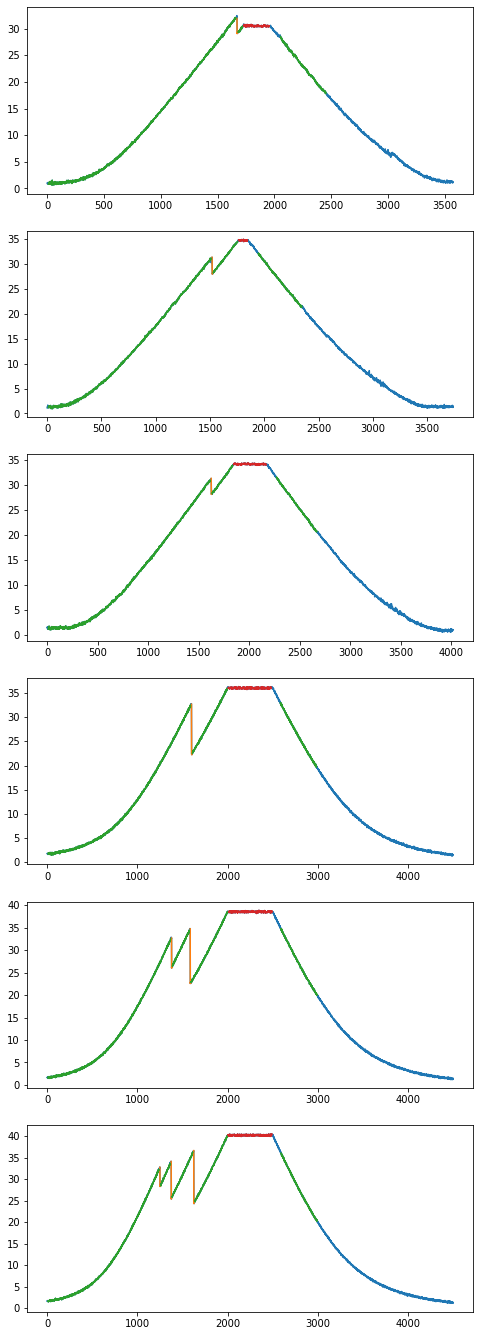

In [9]:
for curve_id, curve in fdcurves.items():
    fdata = curve['force_data']

    top_window = (get_first_trough_index(fdata, debug=DEBUG),
                  get_first_trough_index(fdata, last=True, debug=DEBUG))
    if top_window[1] - top_window[0] > 100:   # stationary state is a good noise window
        unfolds, threshold = find_transitions(fdata,
                                              noise_estimation_window = top_window)
    else:
        unfolds, threshold = find_transitions(fdata)

    #print(unfolds)
    start = 0
    for index, force in enumerate(fdata):
        if force > STARTING_FORCE:
            start = index
            break
    
    events = [start]
    events.extend(unfolds)
    events.append(top_window[0])
    legs = [slice(*[events[i] + OFFSET, events[i+1] - OFFSET]) \
            for i in range(len(events) - 1)]
    if FIT_ON_RETURN:
        legs.append(slice(*[top_window[-1] + FIT_ON_RETURN[0], top_window[-1] + sum(FIT_ON_RETURN)]))
        
    curve['start'] = start
    curve['top'] = top_window
    curve['unfolds'] = unfolds
    curve['threshold'] = threshold
    curve['legs'] = legs


if VERBOSE:
    # plot force over time (or number of measurements)
    # green: fitted leg, orange: unfold event, red: return/stationary point
    plot_events(fdcurves)

## Error-finding
Here we try to filter out datasets based on multiple tethers, particle interference and bead loss.

In [10]:
from util import load_estimates
from copy import deepcopy
from math import exp


def gen_hm():
    return lk.inverted_odijk('handles') + lk.force_offset('handles')

##### Multiple tethers
We filter multiple tethers comparison of the model as given in the estimates, with exaggerated parameters or data. The tests we perform include:
- A doubled persistence length
- A halved contour length
- Halved force data
- Doubled distance data

These should in theory test the single-tether case against the double-tether case. For a greater number of tethers we assume a double-tether model would fit better than a single-tether one. We compare the resulting BICs to determine pass or fail. We also compute Bayes factors for relative likelihood comparisons, but those turn out rather extreme.

Doubling the persistence length yields false positives and does not seem to be a good way to approximate a double tether. Some higher factor would probably work but for now we can just ignore that test.

We may want to hide some of this code behind an import

Halving contour length appears functionally identical to doubling the distance data, so we can do away with one.

In [11]:
original = read_config(cfg_file)['handles']
double_Lp = deepcopy(original)  # can just be reads_config()s,
half_Lc = deepcopy(original)   # we dont need this import
double_Lp['handles/Lp']['value'] = original['handles/Lp']['value'] * 2
half_Lc['handles/Lc']['value'] = original['handles/Lc']['value'] / 2

estimates = {'original': original, 'double_Lp': double_Lp, 
             'half_Lc': half_Lc, 'half_force': original,
            'double_dist': original}

for curve_id, curve in fdcurves.items():
    fdata = curve['force_data']
    ddata = curve['dist_data']
    first_leg = curve['legs'][0]
    
    test_fits = {'original': lk.FdFit(gen_hm()), 'double_Lp': lk.FdFit(gen_hm()),
                'half_Lc': lk.FdFit(gen_hm()), 'half_force': lk.FdFit(gen_hm()),
                'double_dist': lk.FdFit(gen_hm())}
    
    print(curve_id)
    bics = {}
    for key, fit in test_fits.items():
        #print(key)
        if key == 'half_force':
            fit.add_data(f'{curve_id}_{key}',
                        fdata[first_leg] / 2, ddata[first_leg])
        elif key == 'double_dist':
            fit.add_data(f'{curve_id}_{key}',
                        fdata[first_leg], ddata[first_leg] * 2)
        else:
            fit.add_data(f'{curve_id}_{key}',
                        fdata[first_leg], ddata[first_leg])
        load_estimates(fit, estimates[key])
        bics[key] = fit.bic

    bfactors = {}
    tests = {}

    for key, bic in bics.items():
        if VERBOSE:
            print(key, ':', bic)
        if key != 'original':
            bfactors[key] = exp((bics['original'] - bic) / 2)
            tests[key] = bics['original'] > bic  # True => test failed

    curve['BICs'] = bics
    curve['bayes_factors'] = bfactors
    curve['tether_tests'] = tests

Data/adk5_curve1.h5:adk5_curve1
original : 5934.500250366299
double_Lp : 6991.580057033385
half_Lc : 23067.444806576423
half_force : 12006.306512426072
double_dist : 23067.444806576423
Data/adk5_curve2.h5:adk5_curve2
original : 5808.636987529063
double_Lp : 6333.965176778595
half_Lc : 21020.50220966032
half_force : 11017.300102390984
double_dist : 21020.50220966032
Data/adk5_curve3.h5:adk5_curve3
original : 6693.680558308072
double_Lp : 6056.009269970994
half_Lc : 22431.755111999344
half_force : 11768.902681731095
double_dist : 22431.755111999344
simulation_0
original : 5016.895720084637
double_Lp : 7626.222338928107
half_Lc : 22020.212579756106
half_force : 11101.718268746492
double_dist : 22020.212579756106
simulation_1
original : 4237.671272208788
double_Lp : 6595.8601619801175
half_Lc : 18938.948689327306
half_force : 9523.350221683992
double_dist : 18938.948689327306
simulation_2
original : 3893.2969518800583
double_Lp : 5999.160426266023
half_Lc : 17140.62310783419
half_force : 8

In [12]:
for curve_id, curve in fdcurves.items():
    print(curve_id, sum(curve['tether_tests'].values()), curve['tether_tests'])

Data/adk5_curve1.h5:adk5_curve1 0 {'double_Lp': False, 'half_Lc': False, 'half_force': False, 'double_dist': False}
Data/adk5_curve2.h5:adk5_curve2 0 {'double_Lp': False, 'half_Lc': False, 'half_force': False, 'double_dist': False}
Data/adk5_curve3.h5:adk5_curve3 1 {'double_Lp': True, 'half_Lc': False, 'half_force': False, 'double_dist': False}
simulation_0 0 {'double_Lp': False, 'half_Lc': False, 'half_force': False, 'double_dist': False}
simulation_1 0 {'double_Lp': False, 'half_Lc': False, 'half_force': False, 'double_dist': False}
simulation_2 0 {'double_Lp': False, 'half_Lc': False, 'half_force': False, 'double_dist': False}


#### Bead loss and outside interference
We detect bead loss through a sudden drop to zero in force measurements.

Outside interference, as in unintended particles entering laser focus, we try to detect by sharp increases in force measurements. This probably only captures a small set of this kind of error.

## Fitting and results

In [13]:
from util import extract_estimates
def gen_comp():
    comp_wrt_f = lk.odijk('handles') + lk.inverted_marko_siggia_simplified('protein')
    return comp_wrt_f.invert(interpolate = True, 
                             independent_min = 0,
                            independent_max = 90) + lk.force_offset('handles')

In [14]:
for curve_id, curve in fdcurves.items():
    curve['handles_model'] = gen_hm()
    curve['composite_model'] = gen_comp()
    curve['fits'] = [lk.FdFit(curve['handles_model'], curve['composite_model']) for unfold in curve['unfolds']]

In [15]:
for curve_id, curve in fdcurves.items():
    fdata = curve['force_data']
    ddata = curve['dist_data']
    first_leg = curve['legs'][0]
    for fit in curve['fits']:
        fit[curve['handles_model']].add_data(f'{curve_id}_handles',
                                                fdata[first_leg],
                                                ddata[first_leg])
    fit = curve['fits'][0]
    load_estimates(fit, read_config(cfg_file)['handles'])
    fit.fit()
    fit['handles/St'].fixed = True
    fit['handles/Lp'].fixed = True
    fit['handles/Lc'].fixed = True
    
    for other_fit in curve['fits'][1:]:
        load_estimates(other_fit, extract_estimates(fit))
    
    if DEBUG:
        print(curve_id, '\n')
        print(curve['fit'])
        print(curve['legs'])

In [16]:
for curve_id, curve in fdcurves.items():
    fdata = curve['force_data']
    ddata = curve['dist_data']
    model = curve['composite_model']
    fits = curve['fits']
    index = 0
    for fit, leg in zip(fits, curve['legs'][1:]):
        fit[model].add_data(f'{curve_id}_domain_{index}',
                                    fdata[leg],
                                    ddata[leg])
        if FIT_ON_RETURN and index + 3 >= len(curve['legs']):
            legrelax = curve['legs'][-1]
            fit[model].add_data(f'{curve_id}_domain_{index}_relax',
                                        fdata[legrelax],
                                        ddata[legrelax])
        load_estimates(fit, read_config(cfg_file)['protein'])
        if index:  # set Lc lower bound to previous value
            prev_cl = fits[index - 1].params['protein/Lc'].value
            fit.params['protein/Lc'].value = prev_cl + 0.01
            fit.params['protein/Lc'].lower_bound = prev_cl

        fit.fit()
        index += 1

Name                    Value  Unit      Fitted      Lower bound    Upper bound
----------------  -----------  --------  --------  -------------  -------------
handles/Lp         18.1886     [nm]      False               0              100
handles/Lc          0.352257   [micron]  False               0              inf
handles/St        276.823      [pN]      False             250              inf
kT                  4.11       [pN*nm]   False               0                8
handles/f_offset    0          [pN]      False              -6                6
protein/Lp          0.6        [nm]      True                0.6              1
protein/Lc          0.0248292  [micron]  True                0              inf


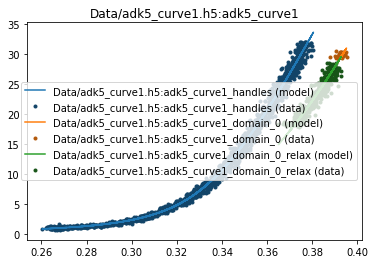

Name                   Value  Unit      Fitted      Lower bound    Upper bound
----------------  ----------  --------  --------  -------------  -------------
handles/Lp         20.241     [nm]      False               0              100
handles/Lc          0.349385  [micron]  False               0              inf
handles/St        253.878     [pN]      False             250              inf
kT                  4.11      [pN*nm]   False               0                8
handles/f_offset    0         [pN]      False              -6                6
protein/Lp          1         [nm]      True                0.6              1
protein/Lc          0.021957  [micron]  True                0              inf


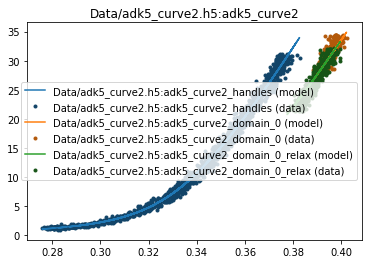

Name                    Value  Unit      Fitted      Lower bound    Upper bound
----------------  -----------  --------  --------  -------------  -------------
handles/Lp         17.0341     [nm]      False               0              100
handles/Lc          0.354532   [micron]  False               0              inf
handles/St        280.225      [pN]      False             250              inf
kT                  4.11       [pN*nm]   False               0                8
handles/f_offset    0          [pN]      False              -6                6
protein/Lp          1          [nm]      True                0.6              1
protein/Lc          0.0223782  [micron]  True                0              inf


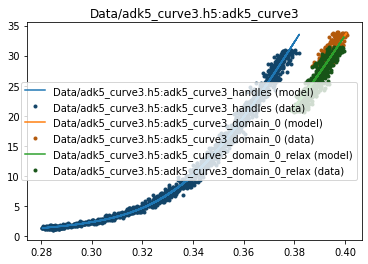

Name                    Value  Unit      Fitted      Lower bound    Upper bound
----------------  -----------  --------  --------  -------------  -------------
handles/Lp         14.6033     [nm]      False               0              100
handles/Lc          0.350442   [micron]  False               0              inf
handles/St        250          [pN]      False             250              inf
kT                  4.11       [pN*nm]   False               0                8
handles/f_offset    0          [pN]      False              -6                6
protein/Lp          0.6        [nm]      True                0.6              1
protein/Lc          0.0254129  [micron]  True                0              inf


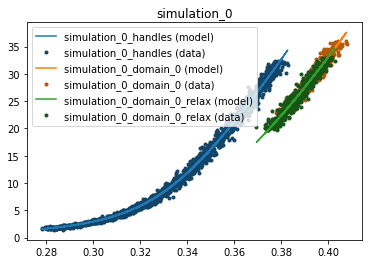

Name                    Value  Unit      Fitted      Lower bound    Upper bound
----------------  -----------  --------  --------  -------------  -------------
handles/Lp         14.7592     [nm]      False               0              100
handles/Lc          0.350205   [micron]  False               0              inf
handles/St        250          [pN]      False             250              inf
kT                  4.11       [pN*nm]   False               0                8
handles/f_offset    0          [pN]      False              -6                6
protein/Lp          0.6        [nm]      True                0.6              1
protein/Lc          0.0155926  [micron]  True                0              inf
Name                    Value  Unit      Fitted      Lower bound    Upper bound
----------------  -----------  --------  --------  -------------  -------------
handles/Lp         14.7592     [nm]      False         0                    100
handles/Lc          0.350205   [micron] 

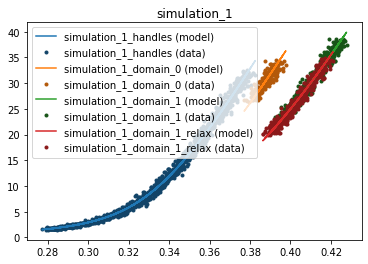

Name                    Value  Unit      Fitted      Lower bound    Upper bound
----------------  -----------  --------  --------  -------------  -------------
handles/Lp         14.5763     [nm]      False               0              100
handles/Lc          0.350303   [micron]  False               0              inf
handles/St        250          [pN]      False             250              inf
kT                  4.11       [pN*nm]   False               0                8
handles/f_offset    0          [pN]      False              -6                6
protein/Lp          0.6        [nm]      True                0.6              1
protein/Lc          0.0103364  [micron]  True                0              inf
Name                    Value  Unit      Fitted      Lower bound    Upper bound
----------------  -----------  --------  --------  -------------  -------------
handles/Lp         14.5763     [nm]      False         0                    100
handles/Lc          0.350303   [micron] 

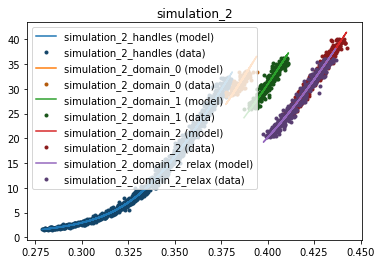

In [17]:
if VERBOSE:
    # plot the fitted models and show fit parameters
    for curve_id, curve in fdcurves.items():
        plt.figure()
        plt.title(curve_id)
        fits = curve['fits']
        fits[0][curve['handles_model']].plot()
        for fit in fits:
            fit[curve['composite_model']].plot()
            print(fit.params)
        plt.show()

#### Computing unfolding forces
We compute the force for each unfolding event by simulating the fitted model to the distance slightly before the unfolding event. This part needs an error estimation.

In [18]:
for curve_id, curve in fdcurves.items():
    unfolds = curve['unfolds']
    models = [curve['composite_model'] for unfold in unfolds[1:]]
    models.insert(0, curve['handles_model'])
    fits = curve['fits']
    unfold_dists = [curve['dist_data'][unfold - 1] for unfold in unfolds]
    unfold_forces = []                # - 1 to make sure we are before unfold
    for dist, fit, model in zip(unfold_dists, fits, models):
        unfold_forces.append(model(dist, fit))
    curve['unfolding_forces'] = unfold_forces
    if VERBOSE:
        print(unfold_forces)

[30.523822627868213]
[31.188609253932746]
[30.93406707745649]
[33.416389367777015]
[30.981377679886336, 22.071073601612454]
[32.34855409745481, 27.18826067160826, 21.581079518116717]


#### Results
Ugly table.

In [19]:
str_format = '{:<32}| {:<5}| {:<9}| {:<9}| {:<9}| {}'
print(str_format.format('Curve', 'fold', 'Lc (um)', 'Lp (nm)', 'Fu (pN)', 'failed tests'))
for curve_id, curve in fdcurves.items():
    total_cl = 0
    for index, fit in enumerate(curve['fits']):
        Lc = round(fit['protein/Lc'].value, 6)
        Lp = round(fit['protein/Lp'].value, 6)
        Fu = round(curve['unfolding_forces'][0], 4)
        tests = curve['tether_tests']
        failed_tests = [test for test in tests.keys() if tests[test]]
        print(str_format.format(curve_id, index + 1, round(Lc - total_cl, 6), Lp, Fu, failed_tests))
        total_cl = Lc

Curve                           | fold | Lc (um)  | Lp (nm)  | Fu (pN)  | failed tests
Data/adk5_curve1.h5:adk5_curve1 | 1    | 0.024829 | 0.6      | 30.5238  | []
Data/adk5_curve2.h5:adk5_curve2 | 1    | 0.021957 | 1.0      | 31.1886  | []
Data/adk5_curve3.h5:adk5_curve3 | 1    | 0.022378 | 1.0      | 30.9341  | ['double_Lp']
simulation_0                    | 1    | 0.025413 | 0.6      | 33.4164  | []
simulation_1                    | 1    | 0.015593 | 0.6      | 30.9814  | []
simulation_1                    | 2    | 0.030723 | 0.6      | 30.9814  | []
simulation_2                    | 1    | 0.010336 | 0.6      | 32.3486  | []
simulation_2                    | 2    | 0.020597 | 0.6      | 32.3486  | []
simulation_2                    | 3    | 0.03077  | 0.6      | 32.3486  | []


In [20]:
print(fdcurves['Data/adk5_curve1.h5:adk5_curve1']['legs'])

[slice(10, 1661, None), slice(1681, 1721, None), slice(2055, 2455, None)]
